# BJT 三极管基础知识复习

陈硕 2024/05 http://nuedc.org/bjt-basics/

In [1]:
%matplotlib inline
%load_ext tikzmagic

from math import exp, log, log10
import numpy as np
from matplotlib import pyplot as plt
import ngspyce as ng

# kΩ μA

def para(r1, r2):
  return (r1*r2) / (r1 + r2)

In [2]:
def print_op(show_ib=True, show_ie=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if '[i' in k or '#branch' in k or '[current]' in k:
        if '[is]' in k:
            continue
        if '[ie]' in k and not show_ie:
            continue
        if '[ib]' in k and not show_ib:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-3:
            print('%10s = %8.3f mA' % (k, 1e3*current))
        else:
            print('%10s = %8.3f uA' % (k, 1e6*current))
    elif '[g' in k:
        gm = op[k][0]
        if gm > 10e-3:
            print('%10s = %8.3f mS' % (k, 1e3 * gm))
        else:
            print('%10s = %8.3f uS' % (k, 1e6 * gm))
    else:  # Voltage
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 10e-3:
            print('%10s = %8.4f V' % (k, voltage))
        else:
            print('%10s = %8.1f uV' % (k, 1e6*voltage))

## 简史

https://www.computerhistory.org/revolution/digital-logic/12/273

1947 年 12 月圣诞节前夜，John Bardeen 和 Walter Brattain 在实验室试制成功了第一个 point-contact transistor。清华童诗白教授在“世纪回眸：纪念晶体管的发明和由此引出的启发”一文中详细介绍了这天实验的经过。

后来在 1948 年 6 月底，Bell Labs 公开了这一发现。为了宣传的需要，实验室让这三人摆拍了著名的照片：
https://www.computerhistory.org/siliconengine/invention-of-the-point-contact-transistor/ 和 https://en.wikipedia.org/wiki/File:Bardeen_Shockley_Brattain_1948.JPG
。为什么说是摆拍？因为 Bardeen 是理论物理学家（后来凭超导理论拿了第二个 Nobel 物理奖），他一般不进实验室，如果要和 Brattain 交流，一般会在自己的办公室就着黑板写写画画。而 Brattain 是实验物理学家，照片是在他的实验室拍的，如果要仔细观察晶体管，那么坐着看显微镜的人应该是他而不是 Shockley.

> Walter Brown debunks the myth created by the Bell Labs press photo: 
"Bardeen was not at all a laboratory experimentalist. He was a theorist. And he was the guy that provided the theoretical ideas for Brattain. It was Brattain who went in the lab and wired up the stuff and put the pieces together. And Bardeen really didn't play a part in the laboratory scene at all. Their association was primarily outside the laboratory. Of course, there is the famous picture of Bardeen, Brattain and Shockley that's taken in Brattain's laboratory. But that really was not a very common—certainly having the three of them together would be very uncommon—but having Brattain and Bardeen together in the laboratory wouldn't have been, that wouldn't have ordinarily happened. It would have happened in Bardeen's office more than it would have been in Brattain's lab." https://www.pbs.org/transistor/album1/addlbios/egos.html

随即，1948 年 7 月，John Bardeen 和 Walter Brattain 在 _Physical Review_ 发表了短短两页的报告
"The Transistor, a Semi-Conductor Triode." [[PDF]](https://journals.aps.org/pr/pdf/10.1103/PhysRev.74.230) 正式命名这个新器件为 transistor，这个名字是他们在 Bell Labs 的同事 [John R. Pierce](https://en.wikipedia.org/wiki/John_R._Pierce) 起的。从 transresistance 变化而来，意思是“跨阻器/传递电阻” transfer resistor。如果我没有理解错，这篇报告展示的是 PNP 管的 common-base 放大电路。https://x.com/TubeTimeUS/status/1249023089528078337

一年后，William Shockley 于 1949/07 在 BSTJ 发表了 "The theory of p-n junctions in semiconductors and p-n junction transistors" https://ieeexplore.ieee.org/document/6773080

五年后，1952 年第一款用晶体管的商业产品上市，是助听器 https://en.wikipedia.org/wiki/Sonotone_1010 ，Bell Labs 当时持有晶体管的专利，但是对助听器类的产品免收专利授权费，这根 Alexander Graham Bell 本人的意愿分不开。 https://www.computerhistory.org/siliconengine/transistorized-consumer-products-appear/ 。

随后 1954 年，晶体管收音机开始普及（Regency TR-1） ，Sony 也凭 TR-52 发展壮大。

* https://www.computerhistory.org/siliconengine/conception-of-the-junction-transistor/
* https://www.worldradiohistory.com/Archive-Electronics/Electronics-1980-04-17-Anniversary.pdf

## Basic model 基本模型
$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$

模拟电路对数学要求不高，只在推导时用一点点微积分知识（[链式求导法则](https://zh.wikipedia.org/wiki/%E9%93%BE%E5%BC%8F%E6%B3%95%E5%88%99) / [Chain rule](https://en.wikipedia.org/wiki/Chain_rule)），在确定小信号条件时用到了[泰勒展开](https://zh.wikipedia.org/wiki/%E6%B3%B0%E5%8B%92%E7%BA%A7%E6%95%B0)。

以下是 SPICE 采用的物理常数，注意 SPICE 用的 $k$ / $q$ 常数是旧值。

In [6]:
ng.vectors()

{'planck': array([6.62607004e-34]),
 'boltz': array([1.38064852e-23]),
 'echarge': array([1.60217662e-19]),
 'kelvin': array([-273.15]),
 'i': array([0.+1.j]),
 'c': array([2.99792458e+08]),
 'e': array([2.71828183]),
 'pi': array([3.14159265]),
 'FALSE': array([0.]),
 'no': array([0.]),
 'TRUE': array([1.]),
 'yes': array([1.])}

[2019 年重新定义 SI 基本单位](https://en.wikipedia.org/wiki/2019_redefinition_of_the_SI_base_units)之后，

* 新的 [Boltzmann常数](https://en.wikipedia.org/wiki/Boltzmann_constant)是精确值 $1.380\,649\times 10^{-23}$ J/K.
* 新的[基本电荷](https://en.wikipedia.org/wiki/Elementary_charge)也是精确值 $ 1.602\,176\,634\times 10 ^{-19}$ C.

为了得到和 SPICE 相近的结果，我们只好也取旧值。

In [7]:
boltz = 1.38064852e-23
echarge = 1.60217662e-19
kelvin = 273.15

room_temperature = 27
Vt = boltz * (room_temperature + kelvin) / echarge
print(Vt)

0.02586491702007235


### Ebers-Moll 大型号模型

以下是放大区的大信号模型，可以看成压控电流源(VCCS)或流空电流源(CCCS)。

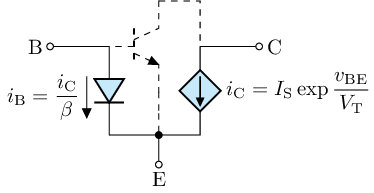

In [4]:
%%tikz -ct
\ctikzset{european voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw [dashed] (0, 0) node [npn] (Q) {}; 
\draw (Q.B) to [D, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (Q.B) to [short, -o] ++(-1, 0) node [left] {B};
\draw [dashed] (Q.E) to [short] (Q.E |- E); 
\draw (Q.E |- E) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (Q) ++(0.7, 0) coordinate (C) 
  to [american controlled current source, l={$\li{C}=\ui{S}\exp\displaystyle\frac{\lv{BE}}{\uv{T}}$}, bipoles/length=1cm] (C|-E)
  -- (E);
\draw (C) to [short, -o] ++(1, 0) node [right] {C};
\draw [dashed] (Q.C) -| (C);
\draw (Q.B)++(-0.1,0) to [open, f_={$\li{B}=\displaystyle\frac{\li{C}}{\beta}$}] ++(0, -1);

In [4]:
Is = 1e-15
Vbe = 0.7
Ic = Is * exp(Vbe / Vt)
gm = Ic / Vt
print('Ic', Ic)
print('gm', gm)

Ic 0.0005670346694806257
gm 0.02192292629590039


In [2]:
ng.circ('''
  Q  c b 0 NPN
  Vc c 0 1V
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm] @q[gpi]
''')
ng.operating_point()
# print_op()

{'@q[gpi]': array([0.00021923]),
 '@q[gm]': array([0.02192293]),
 'vc#branch': array([-0.00056703]),
 'vb#branch': array([-5.67034717e-06]),
 'b': array([0.7]),
 'c': array([1.])}

在 $\uv{A}=\infty$ 的情况下，我们用 Ebers-Moll 模型公式计算的结果与 SPICE 误差小于 1ppm，换言之前 6 位有效数字是相同的。

In [23]:
Ic2 = -ng.vector('vc#branch')[0]
print('%.5f uA (SPICE)' % (Ic2 * 1e6))
print('%.5f uA (EM)' % (Ic * 1e6))

567.03468 uA (SPICE)
567.03467 uA (EM)


In [20]:
Ib2 = -ng.vector('vb#branch')[0]
print('%.7f uA (SPICE)' % (Ib2 * 1e6))
beta = 100
print('%.7f uA (EM)' % (Ic / beta * 1e6))

5.6703472 uA (SPICE)
5.6703467 uA (EM)


In [36]:
gm2 = ng.vector('@q[gm]')[0]
print('%.5f mS (SPICE)' % (gm2 * 1e3))
print('%.5f mS (EM)' % (gm * 1e3))

21.92293 mS (SPICE)
21.92293 mS (EM)


#### Curve tracer

Text(0, 0.5, 'Ic (mA)')

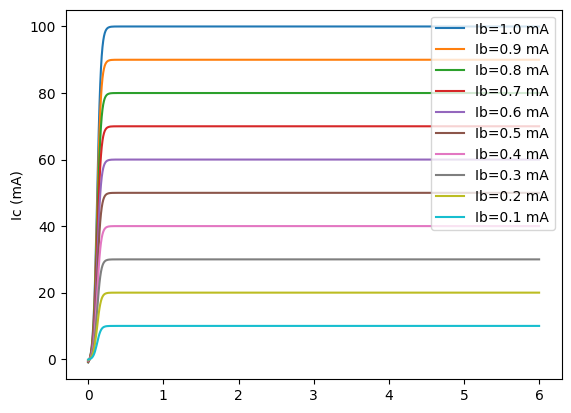

In [6]:
ng.circ("""
  Vcc c 0 10V
  Ib 0 b 10uA
  Q1 c b 0 NPN
  .model NPN NPN(IS=1fA BF=100)
  """)

# manual scan ib
for ib in np.linspace(1000, 100, 10):
    ng.cmd('alter ib %.1fuA' % ib)
    ng.cmd('dc vcc 0 6V 0.01V')
    Ic = -ng.vectors()['vcc#branch']
    Vc = ng.vectors()['v-sweep']
    plt.plot(Vc, Ic * 1e3, label=('Ib=%.1f mA' % (ib/1e3))) #  legend='%.0f uA' % ib)
plt.legend(loc='upper right')
plt.ylabel('Ic (mA)')

### Early effect

Affects $\li{C}$, not $\li{B}$

$\li{C0}=\ui{S}\exp\dfrac{\lv{BE}}{\uv{T}}$

$\li{C}=\li{C0}\Big(1+\dfrac{\lv{CE}}{\uv{A}}\Big)=\ui{S}\exp\dfrac{\lv{BE}}{\uv{T}}\Big(1+\dfrac{\lv{CE}}{\uv{A}}\Big)$

$\li{B}=\dfrac{\li{C0}}{\beta} = \dfrac{\ui{S}}{\beta}\exp\dfrac{\lv{BE}}{\uv{T}}$

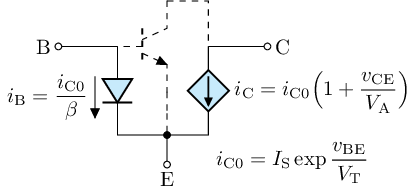

In [66]:
%%tikz -ct -p amsmath
\ctikzset{european voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw [dashed] (0, 0) node [npn] (Q) {}; 
\draw (Q.B) to [D, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (Q.B) to [short, -o] ++(-1, 0) node [left] {B};
\draw [dashed] (Q.E) to [short] (Q.E |- E); 
\draw (Q.E |- E) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (Q) ++(0.7, 0) coordinate (C) 
  to [american controlled current source, l={$\li{C}=\li{C0}\Big(1+\dfrac{\lv{CE}}{\uv{A}}\Big)$}, bipoles/length=1cm] (C|-E)
  node [below right] {$\li{C0}=\ui{S}\exp\displaystyle\frac{\lv{BE}}{\uv{T}}$}
  -- (E);
\draw (C) to [short, -o] ++(1, 0) node [right] {C};
\draw [dashed] (Q.C) -| (C);
\draw (Q.B)++(-0.1,0) to [open, f_={$\li{B}=\displaystyle\frac{\li{C0}}{\beta}$}] ++(0, -1);

In [4]:
ng.circ('''
  Q  c b 0 NPN
  Vc c 0 10V
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100 VAF=130)
  .save all @q[gm]
''')
ng.operating_point()
# print_op()

{'@q[gm]': array([0.0234869]),
 'vc#branch': array([-0.0006076]),
 'vb#branch': array([-5.67033817e-06]),
 'b': array([0.7]),
 'c': array([10.])}

But, SPICE uses $\lv{CB}$, not $\lv{CE}$.

In [8]:
Is = 1e-15
Vbe = 0.7
Ic0 = Is * exp(Vbe / Vt)
Vcb = 10 - Vbe
Vaf = 130
Ic = Ic0 * (1 + Vcb / Vaf)

Ic2 = -ng.vector('vc#branch')[0]
print('%.5f uA (SPICE)' % (Ic2 * 1e6))
print('%.5f uA (EM)' % (Ic * 1e6))

607.59948 uA (SPICE)
607.59946 uA (EM)


In [10]:
Ib2 = -ng.vector('vb#branch')[0]
print('%.7f uA (SPICE)' % (Ib2 * 1e6))
print('%.7f uA (EM)' % (Ic0 / beta * 1e6))

5.6703382 uA (SPICE)
5.6703467 uA (EM)


In [11]:
gm2 = ng.vector('@q[gm]')[0]
print('gm %.3f mS (SPICE)' % (gm2 * 1e3))
print('gm %.3f mS (EM)' % (1e3 * Ic / Vt))

gm 23.487 mS (SPICE)
gm 23.491 mS (EM)


#### Curve tracer

Text(0, 0.5, 'Ic (mA)')

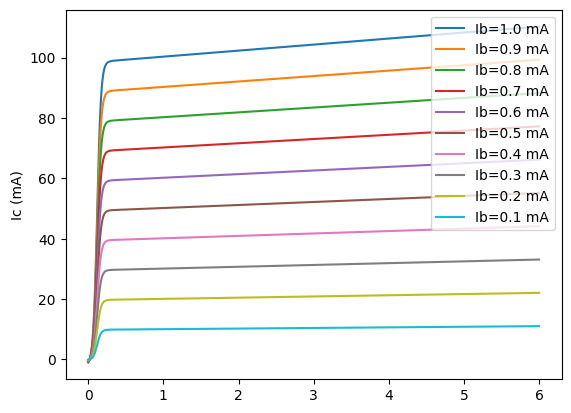

In [8]:
ng.circ("""
  Vcc c 0 10V
  Ib 0 b 10uA
  Q1 c b 0 NPN
  .model NPN NPN(IS=1fA BF=100 VAF=50)
  """)

# manual scan ib
for ib in np.linspace(1000, 100, 10):
    ng.cmd('alter ib %.1fuA' % ib)
    ng.cmd('dc vcc 0 6V 0.01V')
    Ic = -ng.vectors()['vcc#branch']
    Vc = ng.vectors()['v-sweep']
    plt.plot(Vc, Ic * 1e3, label=('Ib=%.1f mA' % (ib/1e3))) #  legend='%.0f uA' % ib)
plt.legend(loc='upper right')
plt.ylabel('Ic (mA)')

### 低频小信号 hybrid-pi 模型

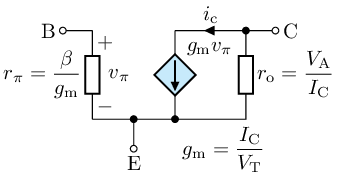

In [5]:
%%tikz -ct
\ctikzset{european resistors, american voltages}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}
\newcommand{\sm}[2]{\ensuremath{{#1}_\mathrm{#2}}}
    
\draw (0,0) to [R, l_={$r_\pi=\displaystyle\frac{\beta}{\sm{g}{m}}$}, v^>={$v_\pi$}, bipoles/length=0.8cm] ++(0, -1.5) coordinate (E);
\draw (0,0) to [short, -o] ++(-0.5, 0) node [left] {B};
%\draw [dashed] (Q.E) to [short] (Q.E |- E);
\draw (E) ++(0.7, 0) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (1.4, 0) coordinate (C)
  node [below right=2pt] {$\sm{g}{m}v_\pi$}
  to [american controlled current source, bipoles/length=1cm] (C|-E) node [circ] {}
  node [below right] {$\sm{g}{m}=\displaystyle\frac{\sm{I}{C}}{\sm{V}{T}}$};
\draw (C) to [short, i<={\sm{i}{c}}] ++(1.2, 0) coordinate (D)
  to [R, l={$\sm{r}{o}=\displaystyle\frac{\sm{V}{A}}{\sm{I}{C}}$}, bipoles/length=0.8cm] (D|-E)-- (E);
\draw (D) to [short, *-o] ++(0.5, 0) node [right] {C};

**跨导 Transconduance** $\sm{g}{m}$

如果基极电压改变了 $\Delta \lv{BE}$，那么集电极电流将改变 $\Delta \li{C}$，跨导 $\sm{g}{m}$ 表示二者的比值，$\sm{g}{m}$ 越大，表明相同 $\Delta \lv{BE}$ 下 $\Delta \li{C}$ 越大，也就是电流的放大能力越大。

$\sm{g}{m}=\dfrac{\Delta \li{C}}{\Delta \lv{BE}} = \dfrac{\mathrm{d}\, \ui{S}\exp \dfrac{\lv{BE}}{\uv{T}}}{\mathrm{d}\, \lv{BE}} = \dfrac{1}{\uv{T}}\ui{S}\exp \dfrac{\uv{BEQ}}{\uv{T}} = \dfrac{\ui{CQ}}{\uv{T}}$

可见对于 BJT 来说，$\sm{g}{m}$ 只跟 $\ui{CQ}$ 和温度 $T$ 有关，$\sm{g}{m} \propto \ui{CQ}$，$\sm{g}{m} \propto \dfrac{1}{T}$。
温度越高 $\sm{g}{m}$ 越小，为了维持 $\sm{g}{m}$ 稳定，有时需要设法让 $\ui{CQ} \propto T$ 。

In [5]:
ng.circ('''
  Q  c b 0 NPN
  Ic 0 c 600u
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100 VAF=130)
  .save all @q[gm] @q[ic]
''')
ng.operating_point()
# print_op()

{'@q[ic]': array([0.0006]),
 '@q[gm]': array([0.02319308]),
 'vb#branch': array([-5.67033991e-06]),
 'b': array([0.7]),
 'c': array([8.25772105])}

In [13]:
Is = 1e-15
Vbe = 0.7
Ic = 0.6e-3
gm = Ic / Vt
gm2 = ng.vector('@q[gm]')[0]
print('gm %.4f mS (SPICE)' % (gm2 * 1e3))
print('gm %.4f mS (EM)' % (gm * 1e3))
print('Delta gm', gm - gm2)

gm 23.1931 mS (SPICE)
gm 23.1974 mS (EM)
Delta gm 4.362405127682212e-06


**输入阻抗 Input impedance** $r_\pi$，国内教材一般用 $\sm{r}{be}$ 或 $\sm{r}{b'e}$ 表示。

如果基极电压改变了 $\Delta \lv{BE}$ 那么基极电流改变 $\Delta \li{B}$

$r_\pi = \dfrac{\Delta \lv{BE}}{\Delta \li{B}}= \dfrac{\uv{T}}{\ui{B}}$

$r_\pi = \dfrac{\beta\, \uv{T}}{\ui{C0}}$

$r_\pi = \dfrac{\beta}{\sm{g}{m}}$ when ignoring Early effects.


In [15]:
Is = 1e-15
Vbe = 0.7
beta = 100
Ib = Is / beta * exp(Vbe / Vt)

print('rpi', Vt / Ib)

rpi 4561.434849083085


In [6]:
ng.cmd('tf v(c) vb')
ng.vectors()

{'@q[ic]': array([0.0006]),
 '@q[gm]': array([0.02319308]),
 'output_impedance_at_V(c)': array([229262.76933649]),
 'vb#Input_impedance': array([4561.32411062]),
 'Transfer_function': array([-5317.31043354])}

以上可见 $r_\pi$ 的计算结果与 SPICE 非常接近。

* $r_\pi \propto \beta$，$\beta$ 越大，$r_\pi$ 越大。
* $r_\pi \propto \dfrac{1}{\ui{CQ}}$，$\ui{CQ}$ 越小，$r_\pi$ 越大。

$\ui{CQ}$ 同时控制 $\sm{g}{m}$ 和 $r_\pi$，
假设 $\beta=100$, $\uv{T}=26$mV，$\uv{A}=130$V，下表是不同 $\ui{C}$ 对应的 $\sm{g}{m}$ 与 $r_\pi$.

| $\ui{C}$ | $\sm{g}{m}$ | $r_\pi$ | $\sm{r}{o}$ |
| --- | --- | --- | --- |
| 10μA | 1/2600 $\Omega^{-1}$ | 260 kΩ | 13 MΩ |
| 100μA | 1/260 $\Omega^{-1}$ | 26 kΩ | 1.3 MΩ | 
| 1mA | 1/26 $\Omega^{-1}$ | 2.6 kΩ | 130 kΩ |
| 10mA | 1/2.6 $\Omega^{-1}$ | 260 Ω | 13 kΩ |

所以，增益（跨导）和输入阻抗是一对矛盾，不可兼得。对于输入级，往往先满足输入阻抗，牺牲掉部分增益，然后靠中间级把增益补回来。

**输出阻抗 Output impedance** $\sm{r}{o}$，国内教材一般用 $\sm{r}{ce}$.

$\sm{r}{o} = \dfrac{\uv{A}}{\ui{C}}$ for $\ui{C}|_{\uv{BC}=0}$

In [8]:
Is = 1e-15
Vbe = 0.7
Vaf = 130
Ic = Is * exp(Vbe / Vt)
ro = Vaf / Ic
print('ro %.3f (SPICE)' % (ng.vector('output_impedance_at_V(c)')[0]))
print('ro %.3f (EM)' % ro)

ro 229262.769 (SPICE)
ro 229262.878 (EM)


**本征增益 Intrinsic gain** $A_0 = \sm{g}{m}\,\sm{r}{o} = \dfrac{\ui{C}}{\uv{T}}\cdot \dfrac{\uv{A}}{\ui{C}} = \dfrac{\uv{A}}{\uv{T}}$

计算结果与 SPICE 有较大误差。

In [10]:
print('A0 %.3f (SPICE)' % (ng.vector('Transfer_function')[0]))
print('A0 -%.3f (EM)' % (Vaf/Vt))

A0 -5317.310 (SPICE)
A0 -5026.113 (EM)


原因在于，$\sm{g}{m}=\dfrac{\ui{C}}{\uv{T}}$ 而 $\sm{r}{o} = \dfrac{\uv{A}}{\ui{C0}}$，经过 Early effect 修正之后就接近多了。

In [9]:
Va = 130
Vcb = 8.25772 - 0.7
print(Va/Vt*(1 + Vcb / Va))

5318.312828657016


## Emitter follower 射极跟随器

主要起阻抗变换的作用，

* 输入阻抗高 $\sm{R}{in} = r_\pi + (1+\beta)\sm{R}{E}$，相当于把负载 $\sm{R}{E}$ 至少放大了 $\beta+1$ 倍
* 输出阻抗低 $\sm{r}{e} = \dfrac{\uv{T}}{\ui{E}}=\dfrac{\alpha}{\sm{g}{m}}$.（$\ui{E}=1$mA 时约为二三十 $\Omega$）

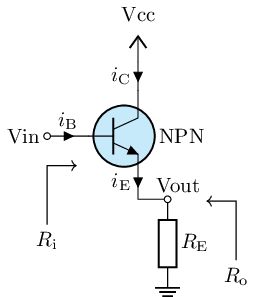

In [33]:
%%tikz -ct
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
    
\draw (0, 0) node [left] {Vin}
to [short, o-, i=$\li{B}$] ++(0.7, 0)
node [npn, tr circle, anchor=B] (Q) {NPN};
\draw (Q.C) to [short,i<=$\li{C}$] ++(0, 0.5) node [vcc] {Vcc};

\draw (Q.E) to [short] ++(0, -0.3) to [short, -o] ++(0.5, 0) node [above] {\quad Vout}
to [R, l=$R_\mathrm{E}$, bipoles/length=1cm] ++(0, -1.5) node [tlground] {};
\draw (Q.E) node [currarrow, rotate=-90] {} node [left] {$\li{E}$};

\draw [->] (0, -1.5) node [below] {$R_\mathrm{i}$} to ++(0, 1) to ++(0.5, 0);
\draw [->] (3.2, -2.1) node [below] {$R_\mathrm{o}$} to ++(0, 1) to ++(-0.5, 0);

In [12]:
ng.circ('''
  Q  c b e NPN
  Vc c 0  10V
  Vb b 0 5.7V
  Re e 0 5000
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm] @q[ie]
''')
#ng.operating_point()
print_op(1, 1)
ng.cmd('tf v(e) vb')
ng.vectors()

    @q[gm] =   38.299 mS
    @q[ie] =   -1.001 mA
         b =   5.7000 V
         c =  10.0000 V
         e =   4.9856 V
 vb#branch =   -9.872 uA
 vc#branch = -987.242 uA


{'@q[ie]': array([-0.00100051]),
 '@q[gm]': array([0.03829897]),
 'output_impedance_at_V(e)': array([25.71886983]),
 'vb#Input_impedance': array([507610.77745333]),
 'Transfer_function': array([0.99485623])}

In [16]:
Ic = 987.242e-6
Ie = Ic * 1.01
re = Vt/Ie
print('Rout', re)

beta = 100
gm = Ic / Vt
rpi = beta / gm
Re = 5e3
Rin = rpi + (1 + beta) * Re
print('Rin', Rin)

Av = Re / (Re + re)
print('Av', Av)

Rout 25.93976829667387
Rin 507619.91659796407
Av 0.9948388222914448


可见计算结果与 SPICE 基本符合

In [36]:
ng.circ('''
  Q  c b e NPN
  Vc c 0  10V
  Vb b 0 5.7V
  Re e 0 5000
  .model NPN NPN(IS=1fA BF=100 VAF=50)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(e) vb')
ng.vectors()

    @q[gm] =   38.277 mS
         b =   5.7000 V
         c =  10.0000 V
         e =   4.9877 V
 vb#branch =   -9.102 uA
 vc#branch = -988.440 uA


{'@q[gm]': array([0.03827686]),
 'output_impedance_at_V(e)': array([25.74153427]),
 'vb#Input_impedance': array([504795.13692927]),
 'Transfer_function': array([0.99438214])}

### Active load

$R_1 < \sm{R}{L}$ 才能保证 Vout 可以低到 Vee + 0.7V.

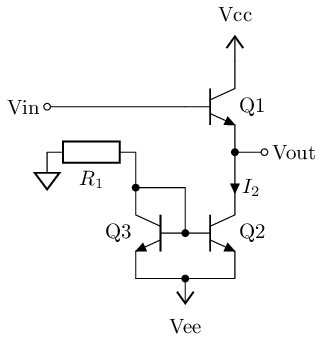

In [36]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {Q1};
\draw (Q1.C) node [vcc] {Vcc};
\draw (Q1.E) to [short, *-o] ++(0.5, 0) node [right] {Vout};
\draw (Q1.E) to [short] ++(0, -0.6)
  node [npn, anchor=C] (Q2) {Q2};
\draw (Q2.B) node [circ] {} node [npn, anchor=B, xscale=-1] (Q3) {\ctikzflipx{Q3}};
\draw (Q3.C) to [short, *-] ++(0, 0.6)
  to [R, l={$R_1$}, bipoles/length=1.2cm] ++(-1.5, 0)
  coordinate (L)
  node [sground] {};
\draw (Q3.E -| Q3.B) node [circ] {} node [vee] {Vee};
\draw (Q3.E) -- (Q2.E);
\draw (Q3.C) -| (Q3.B);
\draw (Q1.B) to [short, -o] (Q1.B-|L) node [left] {Vin};
\draw (Q2.C) node [currarrow, rotate=-90] {} node [right] {$I_2$};

### Push-pull

$\uv{BE}$ 倍增电路有多种实现
https://www.hagtech.com/pdf/vbe.pdf

用两个二极管是最基础的方案，常出现在教材上。

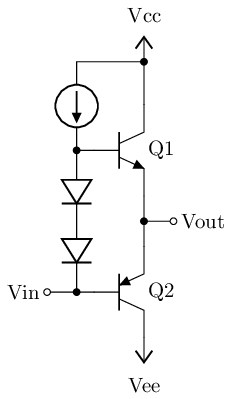

In [23]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {Q1};
% \draw (Q1.C) node [vcc] {Vcc};
\draw (Q1.B) to [short, -*] ++(-0.3, 0)
  to [short] ++(0, -0.2)
  to [D, bipoles/length=1cm] ++(0, -1)
  coordinate (OUT)
  to [D, bipoles/length=1cm] ++(0, -1)
  to [short] ++(0, -0.2)
  to [short, *-] ++(0.3, 0)
  node [pnp, anchor=B] (Q2) {Q2};
\draw (Q1.B) ++(-0.3, 0) to [I, invert, bipoles/length=1.2cm] ++(0, 1.5)
  coordinate (T) -| (Q1.C);
\draw (OUT|-Q2.B) to [short, -o] ++(-0.5, 0) node [left] {Vin};
\draw (T-|Q1.C) node [circ] {} node [vcc] {Vcc};
\draw (Q2.C) node [vee] {Vee};
\draw (Q1.E) -- (Q2.E);
\draw (Q1.E |- OUT) to [short, *-o] ++(0.5, 0) node [right] {Vout};

Vbe 倍增电路也很常见 https://en.wikipedia.org/wiki/Rubber_diode

例如在 LM741 中，$R_1=4.5$kΩ, $R_2=7.5$kΩ

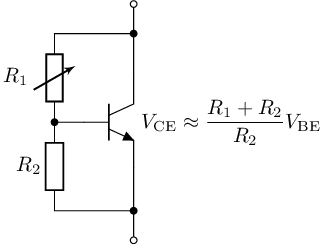

In [15]:
%%tikz -ct -p amsmath
\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {};
\draw (Q1.B) to [short, -*] ++(-0.5, 0)
  coordinate (B);
\draw (B) to [vR, mirror, l={$R_1$}, bipoles/length=1cm] ++(0, 1.5) coordinate (T) -| (Q1.C);
\draw (B) to [R, l_={$R_2$}, bipoles/length=1cm] ++(0, -1.5) coordinate (G) -| (Q1.E);
\draw (T-|Q1.C) to [short, *-o] ++(0, 0.5);
\draw (G-|Q1.E) to [short, *-o] ++(0, -0.5);
\draw (Q1) node [right] {$V_\mathrm{CE}\approx\dfrac{R_1+R_2}{R_2}V_\mathrm{BE}$};

用两个三极管也行，在 µA741 中，R1 是 50kΩ，这个电阻决定了 Q1 的偏置电流 $I_\mathrm{C1}\approx 0.7\mathrm{V} / R_1 = 14$μA.

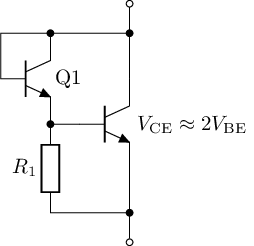

In [20]:
%%tikz -ct -p amsmath
\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {};
\draw (Q1.B) to [short, -*] ++(-0.5, 0)
  coordinate (B);
%\draw (B) to [vR, mirror, l={$R_1$}, bipoles/length=1cm] ++(0, 1.5) coordinate (T) -| (Q1.C);
\draw (B) node [npn, anchor=E] (Q2) {Q1};
\draw (Q2.B) |- (Q2.C) node [circ] {};
\draw (Q2.C) -| (Q1.C);

\draw (B) to [R, l_={$R_1$}, bipoles/length=1cm] ++(0, -1.5) coordinate (G) -| (Q1.E);
\draw (Q2.C -| Q1.C) to [short, *-o] ++(0, 0.5);
\draw (G-|Q1.E) to [short, *-o] ++(0, -0.5);
\draw (Q1) node [right] {$V_\mathrm{CE}\approx 2 V_\mathrm{BE}$};

有时会画成背靠背的形式，电路其实是完全一样的。

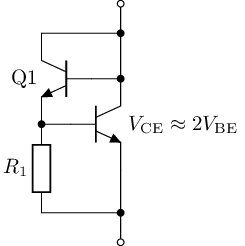

In [24]:
%%tikz -ct -p amsmath
\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {};
\draw (Q1.B) to [short, -*] ++(-0.5, 0)
  coordinate (B);
\draw (B) node [npn, anchor=E, xscale=-1] (Q2) {\ctikzflipx{Q1}};
\draw (Q2.B) to [short, -*] (Q1.C);
\draw (Q2.C) -| (Q1.C);

\draw (B) to [R, l_={$R_1$}, bipoles/length=1cm] ++(0, -1.5) coordinate (G) -| (Q1.E);
\draw (Q2.C -| Q1.C) to [short, *-o] ++(0, 0.5);
\draw (G-|Q1.E) to [short, *-o] ++(0, -0.5);
\draw (Q1) node [right] {$V_\mathrm{CE}\approx 2 V_\mathrm{BE}$};

Vbe 抵消的另一种方案，Q3 抵消 Q1，Q4 抵消 Q2.

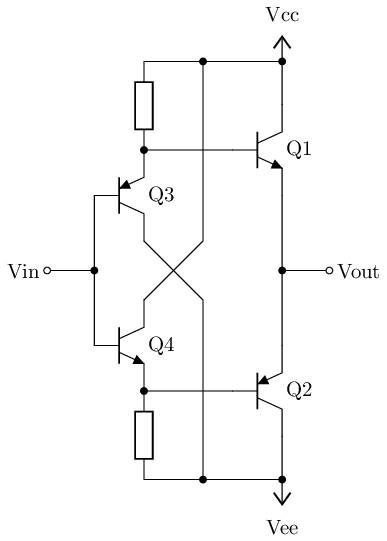

In [40]:
%%tikz -ct
\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {Q1};

\draw (Q1.B) to [short, -*] ++(-1.5, 0)
  node [pnp, anchor=E] (Q3) {Q3};
\draw (Q3.E) to [R, bipoles/length=1cm] ++(0, 1.5)
  coordinate (T) -| (Q1.C);
\draw (T-|Q1.C) node [circ] {} node [vcc] {Vcc};


\draw (Q3.C) ++(0, -0.5) coordinate (M);
\draw (M) ++(0, -0.5)
  node [npn, anchor=C] (Q4) {Q4};
\draw (Q4.E) to [short, *-] ++(1.5, 0)
  node [pnp, anchor=B] (Q2) {Q2};
\draw (Q4.E) to [R, bipoles/length=1cm] ++(0, -1.5)
  coordinate (G) -| (Q2.C);
\draw (G-|Q2.C) node [circ] {} node [vee] {Vee};
\draw (Q4.C) to [short] ++(1, 1) coordinate (Q4C) to [short, -*] (Q4C|-T); 
\draw (Q3.C) to [short] ++(1, -1) coordinate (Q3C) to [short, -*] (Q3C|-G); 

\draw (Q1.E) to [short] (Q2.E);
\draw (Q1.E |- M) to [short, *-o] ++(0.8, 0) node [right] {Vout};

\draw (Q3.B) to (Q4.B);
\draw (Q3.B |- M) to [short, *-o] ++(-0.8, 0) node [left] {Vin};

## Current sources 电流源

### Current mirror 镜像电流源

$\ui{out}=\dfrac{1}{1+2/\beta}\ui{ref}\approx\ui{ref}$

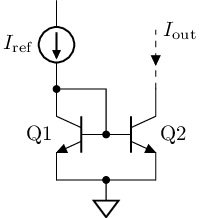

In [25]:
%%tikz -ct
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}

\ctikzset{american voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\draw (0, 0) node [npn, xscale=-1] (Q1) {\ctikzflipx{Q1}};
\draw (Q1.B) node [npn, anchor=B] (Q2) {Q2};
\draw (Q1.E) -- (Q2.E);
\draw (Q1.B |- Q1.E) node [circ] {} node [sground] {};
\draw (Q1.B) node [circ] {} |- (Q1.C) node [circ] {};
\draw (Q1.C) to [I, invert, l={\ui{ref}}, bipoles/length=1cm] ++(0, 1.5);
\draw [dashed] (Q2.C) to [short] ++(0, 1) node [right] {\ui{out}};
\draw (Q2.C) ++(0, 0.5) node [currarrow, rotate=-90] {};

In [17]:
# VAF = ∞
ng.circ('''
  Q1  b  b  0  NPN
  Q2  c  b  0  NPN
  Ir  0  b     1mA
  V1  c  0     5V
  .model NPN NPN(IS=2fA BF=100)
  .options savecurrents
''')
print_op()

@ir[current] = 1000.000 uA
   @q1[ib] =    9.804 uA
   @q1[ic] =  980.398 uA
   @q2[ib] =    9.804 uA
   @q2[ic] =  980.398 uA
         b =   0.6962 V
         c =   5.0000 V
 v1#branch = -980.392 uA


In [60]:
beta = 100
Iref = 1
print(Iref / (1 + 2 / beta))

0.9803921568627451


电流源的输出阻抗与 $\uv{A}$ 直接相关，因此 Early 效应不可忽视。

In [18]:
# VAF = 130
ng.circ('''
  Q1  b  b  0  NPN
  Q2  c  b  0  NPN
  Ir  0  b     1mA
  V1  c  0     5V
  .model NPN NPN(IS=2fA BF=100 VAF=130)
  .options savecurrents
''')
print_op()

@ir[current] = 1000.000 uA
   @q1[ib] =    9.804 uA
   @q1[ic] =  980.398 uA
   @q2[ib] =    9.804 uA
   @q2[ic] =    1.013 mA
         b =   0.6962 V
         c =   5.0000 V
 v1#branch =   -1.013 mA


输出阻抗 $\sm{R}{o}=\sm{r}{o}=\dfrac{\uv{A}}{\ui{C}}=130$kΩ，SPICE 用考虑 Early 效应之前的 $\ui{C0}=0.9804$mA 计算，因此略有出入.

In [20]:
ng.circ('''
  Q1  b  b  0  NPN
  Q2  c  b  0  NPN
  Ir  0  b     1mA
  I2  0  c     1mA
  .model NPN NPN(IS=2fA BF=100 VAF=130)
''')
print_op()
ng.cmd('tf v(c) ir')
ng.vectors()

         b =   0.6962 V
         c =   3.2962 V


{'output_impedance_at_V(c)': array([132599.94718414]),
 'ir#Input_impedance': array([25.86491356]),
 'Transfer_function': array([-132574.08140889])}

集成电路中可以直接控制两个三极管的面积 Area 之比，实现比例电流源。

$\ui{out}\approx\dfrac{\ui{S2}}{\ui{S1}}\ui{ref}=\dfrac{A_2}{A_1}\ui{ref}$

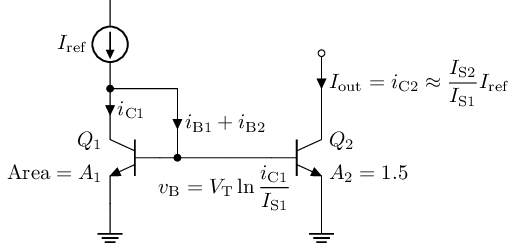

In [46]:
%%tikz -ct -p amsmath

\ctikzset{american currents, american voltages, european resistors}
\ctikzset{diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
%\ctikzset{bipoles/length=1cm};
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}

\draw (0, 0) node [npn, xscale=-1] (Q) {};
\draw (Q) node [above left] {$Q_1$};
\draw (Q) node [below left] {$\mathrm{Area}=A_1$};
\draw (Q.C) to [short, i_<=\li{C1}] ++(0, 0.1)
  to [short, -*] ++(0, 0.3) coordinate (A);
\draw (Q.B) to [short] ++(0.3, 0) coordinate (B);
\draw (A) -- (A-|B) to [short, i={$\li{B1}+\li{B2}$}] (B);
\draw (Q.E) to [short, %i={$\li{E1}=\ui{S1}\exp\dfrac{\lv{B}}{\uv{T}}$},
n=E] ++(0, -0.1)
  node [ground] {} coordinate (K);
%\draw (A)++(0.3, 0.3) node [right] {$\lv{B} = f(\ui{ref})$};

\draw (A) %to [short, i<=\ui{ref}] ++(0, 0.6)
  to [I, invert, l={$\ui{ref}$},bipoles/length=1cm] ++(0, 1.5);
  %node [vcc] {Vcc};
\draw (B) to [short, *-] ++(0.8, 0) coordinate (VO)
  node [below] {$\lv{B}=\uv{T}\ln\dfrac{\li{C1}}{\ui{S1}}$};
\draw (VO) to [short] ++(0.8, 0) coordinate (B);
\draw (B) node [npn, anchor=B] (Q2) {};
\draw (Q2) node [above right] {$Q_2$};
\draw (Q2) node [below right] {$A_2=1.5$};
\draw (Q2.E) to [short, % i={$\li{E2}=\ui{S2}\exp\dfrac{\lv{B}}{\uv{T}}$},
n=E] ++(0, -0.1)
  node [ground] {} coordinate (K);
\draw (Q2.C) to [short, -o, i_<={$\ui{out}=\li{C2}\approx\dfrac{\ui{S2}}{\ui{S1}}\ui{ref}$}] ++(0, 1);

In [62]:
# VAF = 130
ng.circ('''
  Q1  b  b  0  NPN
  Q2  c  b  0  NPN   1.5
  Ir  0  b     1mA
  V1  c  0     5V
  .model NPN NPN(IS=2fA BF=100 VAF=130)
  .options savecurrents
''')
print_op()

@ir[current] = 1000.000 uA
   @q1[ib] =    9.756 uA
   @q1[ic] =  975.616 uA
   @q2[ib] =   14.634 uA
   @q2[ic] =    1.512 mA
         b =   0.6961 V
         c =   5.0000 V
 v1#branch =   -1.512 mA


### Emitter resistor

在发射极接电阻可以大大增加电流源的输出阻抗。

国内教材一般以此电路来讲比例电流源，实际上集成电路中可以直接控制两个三极管的面积，实现比例电流。

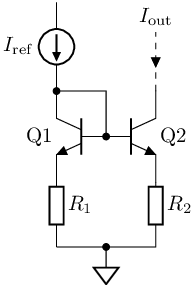

In [34]:
%%tikz -ct
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}

\ctikzset{american voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\draw (0, 0) node [npn, xscale=-1] (Q1) {\ctikzflipx{Q1}};
\draw (Q1.B) node [npn, anchor=B] (Q2) {Q2};
\draw (Q1.E) to [R, l={$R_1$}, bipoles/length=0.8cm] ++(0, -0.8)
  to [short] ++(0, -0.3) coordinate (G);
\draw (Q2.E) to [R, l={$R_2$}, bipoles/length=0.8cm] ++(0, -0.8) |- (G);
\draw (Q1.B |- G) node [circ] {} node [sground] {};
\draw (Q1.B) node [circ] {} |- (Q1.C) node [circ] {};
\draw (Q1.C) to [I, invert, l={\ui{ref}}, bipoles/length=1cm] ++(0, 1.5);
\draw [dashed] (Q2.C) to [short] ++(0, 1) node [above] {\ui{out}};
\draw (Q2.C) ++(0, 0.5) node [currarrow, rotate=-90] {};


$\sm{R}{o}\approx\sm{r}{o}[1+\sm{g}{m}(\sm{R}{2}/\!/r_\pi)] = \dfrac{\uv{A}}{\ui{C2}}\big[1+\dfrac{\ui{C2}}{\uv{T}}(\sm{R}{E}/\!/\dfrac{\beta\uv{T}}{\ui{C2}})\big]$

In [7]:
Va = 130
Ic2 = 0.98
Vt = 26
Re = 1000
beta = 100
rpi = beta * Vt / Ic2
ro = Va / Ic2
gm = Ic2 / Vt
print('Ro = %.1f kΩ' % (ro * (1 + gm * para(Re, rpi))))

Ro = 3763.9 kΩ


In [59]:
# VAF = 130
ng.circ('''
  Q1  b  b  e1  NPN
  Q2  c  b  e2  NPN
  R1  e1 0  1k
  R2  e2 0  1k
  Ir  0  b  1mA
  V1  c  0  5V
  .model NPN NPN(IS=2fA BF=100 VAF=130)
  .options savecurrents
''')
print_op()

@ir[current] = 1000.000 uA
   @q1[ib] =    9.806 uA
   @q1[ic] =  980.629 uA
   @q2[ib] =    9.571 uA
   @q2[ic] =  981.492 uA
    @r1[i] =  990.429 uA
    @r2[i] =  991.057 uA
         b =   1.6867 V
         c =   5.0000 V
        e1 =   0.9904 V
        e2 =   0.9911 V
 v1#branch = -981.486 uA


$R_1=R_2=1$kΩ，输出阻抗从 130kΩ 增加到了 3.13MΩ

In [74]:
# VAF = 130
ng.circ('''
  Q1  b  b  e1  NPN
  Q2  c  b  e2  NPN
  R1  e1 0  1k
  R2  e2 0  1k
  Ir  0  b  1mA
  I2  0  c  0.982mA
  .model NPN NPN(IS=2fA BF=100 VAF=130)
  * .options savecurrents
''')
print_op()
ng.cmd('tf v(c) ir')
ng.vectors()

         b =   1.6868 V
         c =   6.5961 V
        e1 =   0.9905 V
        e2 =   0.9915 V


{'output_impedance_at_V(c)': array([3133068.88896781]),
 'ir#Input_impedance': array([804.88798517]),
 'Transfer_function': array([-3072885.30948549])}

### Widlar 微电流源

$ \ui{C2}\approx\ui{E2}$

$\uv{R2} = \ui{out} R_2 = \uv{T}\ln \dfrac{\ui{ref}}{\ui{out}}$ 是个超越方程。

在设计电路时，已知 $\ui{out}$ 求 $R_2$ 很容易。

在分析电路时，已知 $R_2$ 求 $\ui{out}$ 不太容易，现在一般可用数值方法求近似解。

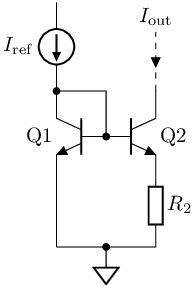

In [33]:
%%tikz -ct
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}

\ctikzset{american voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\draw (0, 0) node [npn, xscale=-1] (Q1) {\ctikzflipx{Q1}};
\draw (Q1.B) node [npn, anchor=B] (Q2) {Q2};
\draw (Q1.E) to [short] ++(0, -1.1) coordinate (G);
\draw (Q2.E) to [R, l={$R_2$}, bipoles/length=0.8cm] ++(0, -0.8)
  to [short] ++(0, -0.3) -- (G);
\draw (Q1.B |- G) node [circ] {} node [sground] {};
\draw (Q1.B) node [circ] {} |- (Q1.C) node [circ] {};
\draw (Q1.C) to [I, invert, l={\ui{ref}}, bipoles/length=1cm] ++(0, 1.5);
\draw [dashed] (Q2.C) to [short] ++(0, 1) node [above] {\ui{out}};
\draw (Q2.C) ++(0, 0.5) node [currarrow, rotate=-90] {};

In [49]:
Ic1 = 1e-3  # 1mA
Ic2 = 20e-6  # 20μA
Vt = 26e-3
R1 = Vt * log(Ic1 / Ic2) / Ic2
print('R1 = %.1f kΩ' % (R1 / 1e3))

R1 = 5.1 kΩ


In [55]:
import scipy
def Ic2(x):
    Ic = x
    Vt = 26
    Iref = 1000  # μA
    R = 5.1  # kΩ
    return Ic * R - Vt * np.log(Iref / Ic)

root = scipy.optimize.root_scalar(Ic2, x0=0.1)
if root.converged:
    Ic = root.root
    print('Iout = %.1f uA' % (Ic))

Iout = 20.0 uA


In [12]:
# VAF = 130
ng.circ('''
  Q1  b  b  0  NPN
  Q2  c  b  e2  NPN
  R2  e2 0  5.1k
  Ir  0  b  1mA
  V1  c  0  5V
  .model NPN NPN(IS=2fA BF=100 VAF=130)
  .options savecurrents
''')
print_op()

@ir[current] = 1000.000 uA
   @q1[ib] =    9.899 uA
   @q1[ic] =  989.909 uA
   @q2[ib] =    0.192 uA
   @q2[ic] =   19.810 uA
    @r2[i] =   20.002 uA
         b =   0.6965 V
         c =   5.0000 V
        e2 =   0.1020 V
 v1#branch =  -19.810 uA


$\sm{R}{o}\approx\sm{r}{o}[1+\sm{g}{m}(\sm{R}{2}/\!/r_\pi)]$

In [18]:
Va = 130
Ic2 = 20e-3
Vt = 26
Re = 5100
beta = 100
rpi = beta * Vt / Ic2
ro = Va / Ic2
gm = Ic2 / Vt
print('Ro = %.1f MΩ' % (ro * (1 + gm * para(Re, rpi))/1e3))

Ro = 31.0 MΩ


In [16]:
ng.circ('''
  Q1  b  b  0   NPN
  Q2  c  b  e2  NPN
  R2  e2 0  5.1k
  Ir  0  b  1mA
  I2  0  c  19.8uA
  .model NPN NPN(IS=2fA BF=100 VAF=130)
  * .options savecurrents
''')
print_op()
ng.cmd('tf v(c) ir')
ng.vectors()

         b =   0.6965 V
         c =   4.6665 V
        e2 =   0.1020 V


{'output_impedance_at_V(c)': array([32211128.891864]),
 'ir#Input_impedance': array([25.86509525]),
 'Transfer_function': array([-129046.61063506])}

在有些 1980 年代的教材上，会介绍用图解法从 $R_2$ 求 $\ui{out}$，步骤如下：

Iref = 1mA

R = 5k

R * Iref = 5

从横坐标=5 找到对应的纵坐标，约为 50，即

Iref / Iout = 50

Iout = Iref / 50 = 20uA

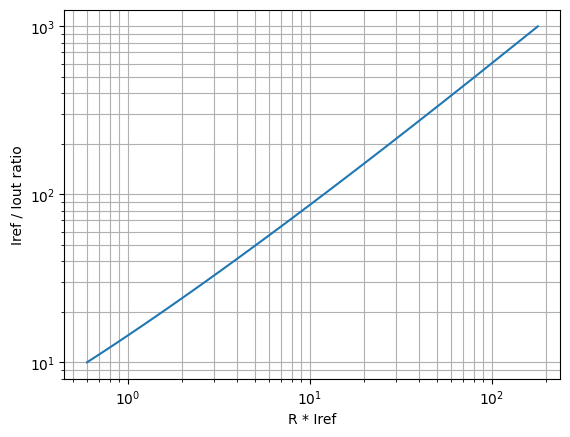

In [56]:
Ic1 = 1e-3  # 1mA
Ic2 = np.arange(1, 101) / 1e6
Vt = 26e-3
R1 = Vt * np.log(Ic1 / Ic2) / Ic2
plt.loglog(R1*Ic1, Ic1/Ic2)
plt.ylabel('Iref / Iout ratio')
plt.xlabel('R * Iref')
plt.grid(which='both')

5.727926509844882 14.226513400823785


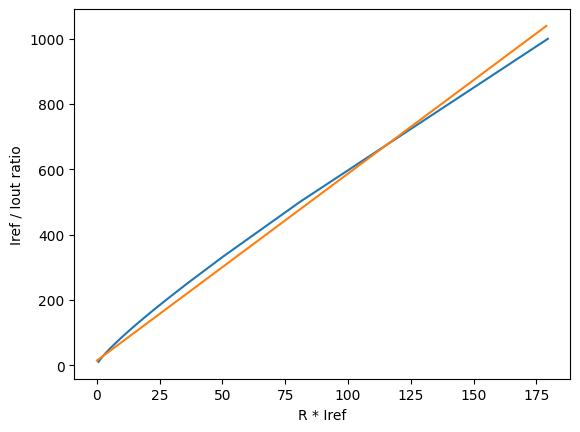

In [27]:
plt.plot(R1*Ic1, Ic1/Ic2)
plt.ylabel('Iref / Iout ratio')
plt.xlabel('R * Iref')
#plt.grid(which='both')

m, b = np.polyfit(R1*Ic1, Ic1/Ic2, 1)
x = np.arange(0, 180)
print(m, b)
plt.plot(x, m*x + b)

## Common-Emitter amplifier

Load resistor $\sm{R}{C}$

电压增益 $\sm{A}{v} = \sm{g}{m}\sm{R}{C} = \dfrac{\ui{C} \sm{R}{C}}{\uv{T}} < \dfrac{\uv{CC}}{\uv{T}}$，注意 $\sm{A}{v}$ 和 $\beta$ 无关，只和工作点 $\ui{C}$ 有关。

对于 $\uv{CC} = 15$V，$\sm{A}{v} < 580$，且随温度增加会下降。
一般为了获得最大的电压摆幅，会令 $\ui{CQ}\sm{R}{C}=\dfrac{\uv{CC}}{2}$，这样一来 $\sm{A}{v}$ 也就确定了，为 $\dfrac{\uv{CC}}{2\uv{T}}$。

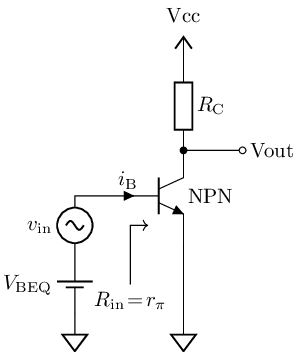

In [2]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q) {NPN};
\draw (Q.B) to [short, i_<={$i_\mathrm{B}$}] ++(-0.2, 0)
  to [short] ++(-0.8, 0)
  to [sV, l_=$v_\mathrm{in}$, bipoles/length=1cm] ++(0, -1)
  to [battery1, l_={$V_\mathrm{BEQ}$}, bipoles/length=1cm]  ++(0, -1)
  coordinate (G) node [sground] {};
\draw (Q.E) to [short] (G-|Q.E) node [sground] {};
\draw (Q.C) to [R, l_={$R_\mathrm{C}$}, bipoles/length=1cm] ++(0, 1.5)
  node [vcc] {Vcc};
\draw [->] (-0.9, -1.5) node [below] {$R_\mathrm{in}\!=\!r_\pi$} to ++(0, 1) to ++(0.3, 0);

\draw (Q.C) to [short, *-o] ++(1, 0) node [right] {Vout};

In [8]:
ng.circ('''
  Q  c b 0 NPN
  Vc vcc 0  10V
  Vb b 0 0.7V
  Rc vcc c  10k
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

    @q[gm] =   21.923 mS
         b =   0.7000 V
         c =   4.3297 V
 vb#branch =   -5.670 uA
 vc#branch = -567.035 uA
       vcc =  10.0000 V


{'@q[gm]': array([0.02192293]),
 'output_impedance_at_V(c)': array([9999.9998]),
 'vb#Input_impedance': array([4561.43018212]),
 'Transfer_function': array([-219.22926164])}

In [74]:
Is = 1e-15
Vbe = 0.7
Ic = Is * exp(Vbe / Vt)
gm = Ic / Vt
print('Ic ', Ic)
print('gm ', gm)
beta = 100
print('Rin', beta/gm)
Rc = 10e3
print('Av ', gm * Rc)

Ic  0.0005670346694806257
gm  0.02192292629590039
Rin 4561.434849083085
Av  219.2292629590039


#### Early effect

* $\ui{C}=\ui{C0}\Big(1+\dfrac{\uv{CE}}{\uv{A}}\Big)$

* $\sm{g}{m}=\dfrac{\ui{C}}{\uv{T}}$
* $\sm{r}{o}=\dfrac{\uv{A}}{\ui{C0}}$
* $\sm{R}{o} = \sm{R}{C} /\!/ \sm{r}{o}$
* $\sm{A}{v} = \sm{g}{m}\sm{R}{o} = \sm{g}{m}( \sm{R}{C} /\!/ \sm{r}{o})$

In [17]:
ng.circ('''
  Q  c b 0 NPN
  Vc vcc 0  10V
  Vb b 0 0.7V
  Rc vcc c  10k
  .model NPN NPN(IS=1fA BF=100 VAF=130)
  .save all @q[gm] @q[ic]
''')
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

    @q[gm] =   22.505 mS
    @q[ic] =  582.205 uA
         b =   0.7000 V
         c =   4.1780 V
 vb#branch =   -5.670 uA
 vc#branch = -582.205 uA
       vcc =  10.0000 V


{'@q[ic]': array([0.0005822]),
 '@q[gm]': array([0.02250508]),
 'output_impedance_at_V(c)': array([9582.04947524]),
 'vb#Input_impedance': array([4561.4302567]),
 'Transfer_function': array([-215.64478285])}

In [18]:
Is = 1e-15
Vbe = 0.7
Vcb = 4.1780 - Vbe
Vaf = 130
Ic0 = Is * exp(Vbe / Vt)
Ic = Ic0 * (1 + Vcb / Vaf)
gm = Ic / Vt
print('Ic', Ic)
print('gm', gm)
ro = Vaf / Ic0
Rc = 10e3
Ro = para(Rc, ro)
print('Ro', Ro)
print('Av', gm * Ro)

Ic 0.0005822050277918073
gm 0.022509448893263014
Ro 9582.049664282067
Av 215.6866572108652


## Common-Emitter with degeneration

在发射极和地之间串接电阻 $\sm{R}{E}$ 可大大增加 $r_\pi$，代价是大大降低 $\sm{A}{v}$

$\sm{R}{in} = r_\pi + (1+\beta)\sm{R}{E}$

$A =\dfrac{\sm{R}{C}}{\sm{r}{e}+\sm{R}{E}} \approx \dfrac{R_\mathrm{C}}{R_\mathrm{E}}$

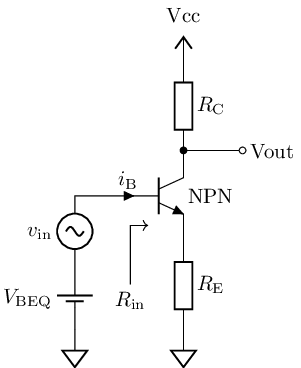

In [72]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q) {NPN};
\draw (Q.E) to [R, l={$R_\mathrm{E}$}, bipoles/length=1cm] ++(0, -1.5)
  coordinate (G) node [sground] {};

\draw (Q.B) to [short, i_<={$i_\mathrm{B}$}] ++(-0.2, 0)
  to [short] ++(-0.8, 0) coordinate (B)
  to [sV, l_=$v_\mathrm{in}$, bipoles/length=1cm] ++(0, -1.2)
  to [battery1, l_={$V_\mathrm{BEQ}$}, bipoles/length=1cm]  (B|-G)
  node [sground] {};
  
\draw (Q.C) to [R, l_={$R_\mathrm{C}$}, bipoles/length=1cm] ++(0, 1.5)
  node [vcc] {Vcc};
\draw [->] (-0.9, -1.5) node [below] {$R_\mathrm{in}$} to ++(0, 1) to ++(0.3, 0);
\draw (Q.C) to [short, *-o] ++(1, 0) node [right] {Vout};

In [25]:
ng.circ('''
  Q  c b e NPN
  Vc vcc 0  10V
  Vb b 0 0.8V
  Rc vcc c  10k
  Re e 0 200
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

    @q[gm] =   19.675 mS
         b =   0.8000 V
         c =   4.9110 V
         e =   0.1028 V
 vb#branch =   -5.089 uA
 vc#branch = -508.900 uA
       vcc =  10.0000 V


{'@q[gm]': array([0.0196753]),
 'output_impedance_at_V(c)': array([9999.9998]),
 'vb#Input_impedance': array([25282.48933506]),
 'Transfer_function': array([-39.55302566])}

In [59]:
Ic = 508.9e-6
gm = Ic / Vt
print('gm ', gm)

Ie = Ic * 1.01
re = Vt / Ie
print('re ', re)

beta = 100
rpi = beta / gm
Re = 200
Rin = rpi + (1+beta)*Re
print('Rin', Rin)

Rc = 10e3
print('Av ', Rc / (Re + re))

gm  0.019675299928666713
re  50.3219271620061
Rin 25282.514643362614
Av  39.94855789652055


可见 $\sm{R}{E}=200\Omega$，而 $\sm{R}{in}$ 从 $r_\pi=5$kΩ 左右增大到了 25kΩ，增加了 $(1+\beta)\sm{R}{E}=20\mathrm{k}\Omega$.

### 教材常讲的偏置电路

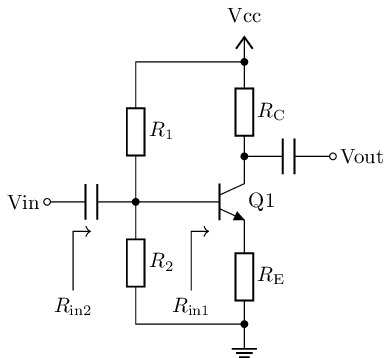

In [25]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {Q1};
\draw (Q1.B) to [short, -*] ++(-1.0, 0)
  coordinate(B);
\draw (Q1.E) to [R, l={$R_\mathrm{E}$}, bipoles/length=1cm] ++(0, -1.0)
  to [short] ++(0, -0.3)
  coordinate (G) node [ground] {};
\draw (Q1.C) to [R, l_={$R_\mathrm{C}$}, bipoles/length=1cm] ++(0, 1.5)
  to [short] ++(0, 0.1) node [vcc] {Vcc}
  coordinate (T);
\draw (B) to [R,l_={$R_1$}, bipoles/length=1cm] (B|-T) to [short, -*] (T);
\draw (B) to [R,l={$R_2$}, bipoles/length=1cm] (B|-G) to [short, -*] (G);
\draw (Q1.C) node [circ] {} to [C, bipoles/length=1cm] ++(1.5, 0) node [ocirc] {}
  node [right] {Vout};
\draw (B) to [C, bipoles/length=1cm] ++(-1.5, 0) node [ocirc] {}
  node [left] {Vin};
\draw [->] (-0.9, -1.5) node [below] {$R_\mathrm{in1}$} to ++(0, 1) to ++(0.3, 0);
\draw [->] (-2.9, -1.5) node [below] {$R_\mathrm{in2}$} to ++(0, 1) to ++(0.3, 0);

$\sm{A}{v}=\dfrac{\sm{R}{C}}{1/\sm{g}{m}+\sm{R}{E}}\approx\dfrac{\sm{R}{C}}{\sm{R}{E}}$

$\sm{R}{in1} = r_\pi + (1+\beta)\sm{R}{E}$

$\sm{R}{in2}=R_1 /\!/ R_2 /\!/ \sm{R}{in1}$

$\sm{R}{o}=\sm{R}{C}$


分析直流工作点：先根据 R1/R2 分压点求出 $\uv{B}$，然后算出 $\uv{E}\approx\uv{B}-0.7$V.

$\ui{C}\approx\ui{E}=\dfrac{\uv{E}}{\sm{R}{E}}$，最后算出 $\uv{C}=\uv{CC}-\ui{C}\sm{R}{C}$

对于设计来说，一般先定 $\uv{C}=\uv{CC}/2$，再选择工作点 $\ui{C}$，这就确定了 $\sm{R}{C} = \dfrac{\uv{CC}-\uv{C}}{\ui{C}}$

再根据电压放大倍数 $\sm{A}{v}$ 算出 $\sm{R}{E}$

然后就可以算出 $\uv{E}=\ui{E}\,\sm{R}{E}$，以及 $\uv{B}\approx \uv{E}+0.7$V，最后求出 $R_1$、$R_2$.

## Common-Emitter with active load

有源负载可以大大增加 $\sm{A}{v}$，通常可以达到 $1000\sim 2000$

输出阻抗 $\sm{R}{o}=\sm{r}{o1}/\!/\sm{r}{o2}=\dfrac{1}{\dfrac{1}{\sm{r}{o1}}+\dfrac{1}{\sm{r}{o2}}}=\dfrac{1}{\dfrac{\ui{C}}{\uv{A1}} + \dfrac{\ui{C}}{\uv{A2}}} =\dfrac{1}{\ui{C}}\cdot\dfrac{\uv{A1}\uv{A2}}{\uv{A1}+\uv{A2}}$

开路增益 $\sm{A}{v}=\sm{g}{m}\sm{R}{o}=\sm{g}{m}(\sm{r}{o1}/\!/\sm{r}{o2})=\dfrac{\uv{A1}\uv{A2}}{\uv{T}(\uv{A1}+\uv{A2})}$ 跟偏置电流 $\ui{C}$ 无关，但是输出阻抗 $\sm{R}{o}$ 跟偏置电流成反比，为了提高带负载的能力，应该增加偏置电流。

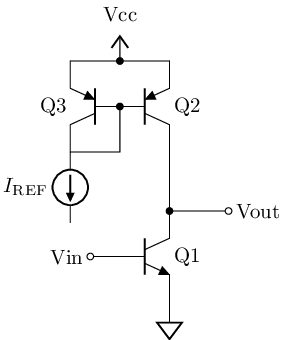

In [36]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [pnp, xscale=-1] (Q3) {\ctikzflipx{Q3}};
\draw (Q3.B) node [pnp, anchor=B] (Q2) {Q2};
\draw (Q3.E) -- (Q2.E);
\draw (Q3.E) coordinate (T);
\draw (T-|Q3.B) node [circ] {} node [vcc] {Vcc};
\draw (Q3.C) -| (Q3.B) node [circ] {};
\draw (Q3.C) to [I, l_={$I_\mathrm{REF}$}, bipoles/length=1cm] ++(0, -1.2);

\draw (Q2.C) to [short] ++(0, -1)
  node [npn, anchor=C] (Q1) {Q1};
\draw (Q1.C) to [short, *-o] ++(1, 0) node [right] {Vout};
\draw (Q1.B) to [short, -o] ++(-0.5, 0) node [left] {Vin};
\draw (Q1.E) node [sground] {};

In [48]:
Va1 = 130
Va2 = 50
print(Va1*Va2/(Vt*(Va1+Va2)))

1396.142546410926


In [51]:
ng.circ('''
  Q3  bias  bias  vcc  PNP
  Q2  c     bias  vcc  PNP
  Q1  c     b     0    NPN
  R1  bias  0  15k
  Vcc  vcc  0  15V
  Vin  b  0  0.715V
  * .options savecurrents
  .save all @q1[ic] @q1[gm]
  .model PNP PNP(IS=1fA BF=80  VAF=50)
  .model NPN NPN(IS=1fA BF=100 VAF=130)
''')
print_op()
ng.cmd('tf  v(c)  vin')
ng.vectors()

   @q1[gm] =   41.073 mS
   @q1[ic] =    1.063 mA
         b =   0.7150 V
      bias =  14.2872 V
         c =   7.1154 V
       vcc =  15.0000 V
vcc#branch =   -2.015 mA
vin#branch =  -10.127 uA


{'@q1[gm]': array([0.04107253]),
 '@q1[ic]': array([0.00106254]),
 'output_impedance_at_V(c)': array([37914.88514855]),
 'vin#Input_impedance': array([2554.0928264]),
 'Transfer_function': array([-1557.26029682])}

In [47]:
Vbe1 = 0.715
Is = 1e-15
Ic1 = Is * exp(Vbe1 / Vt)
rpi1 = 100 * Vt / Ic1
print('rpi', rpi1)
ro1 = Va1 / Ic1

# PNP
Vbe2 = 15-14.2872
Ic2 = Is * exp(Vbe2 / Vt)
ro2 = Va2 / Ic2
Ro = para(ro1, ro2)
print('Ro', Ro)

gm = 1.063e-3 / Vt
print('Av ', gm * Ro)

rpi 2554.103034638456
Ro 37890.28761381275
Av  1557.2203731496945


## CC-CE stage

|  | Common-Emitter | Common-Collector |
| --- | --- | --- |
| $\sm{R}{in}$ | $r_\pi$ （较低，数 kΩ） | $r_\pi + (1+\beta) \sm{R}{E}$ （高，数百 kΩ）|
| $\sm{A}{v}$ | $\sm{g}{m}\sm{R}{o}$ （可上百） | $< 1$（低） |

所以，CC-CE 可同时做到高 $\sm{R}{in}$ 和高 $\sm{A}{v}$，这也是运放的增益级常用 CC-CE 结构的原因，因为输入级通常偏置电流很小（几个微安）），那么输出阻抗会很大，因此需要先接一级 emitter follower 与之匹配。

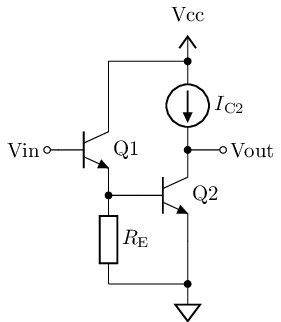

In [50]:
%%tikz -ct
\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors}

\draw (0, 0) node [npn] (Q1) {Q1};
\draw (Q1.E) to [short, *-] ++(0.5, 0)
  node [npn, anchor=B] (Q2) {Q2};
\draw (Q1.E) to [R, l={$R_\mathrm{E}$}, bipoles/length=1cm] ++(0, -1.5) coordinate (G);
\draw (Q2.C) to [I, invert, l_={$I_\mathrm{C2}$}, bipoles/length=1.2cm] ++(0, 1.5) coordinate (T);
\draw (Q1.C) |- (T) node [circ] {} node [vcc] {Vcc};
\draw (Q2.E) |- (G);
\draw (Q2.E |- G) node [circ] {} node [sground] {};
\draw (Q2.C) to [short, *-o] ++(0.6, 0) node [right] {Vout};
\draw (Q1.B) to [short, -o] ++(-0.2, 0) node [left] {Vin};

$\sm{R}{i1} =r_{\pi 1} +(1+\beta)(\sm{R}{E}/\!/ r_{\pi2})$

假设 $\sm{R}{E}=50$kΩ，$\ui{C2}=1$mA，$\uv{BE2}=0.7$V，那么 

* $\ui{E1}=\ui{RE}+\ui{B2} = \dfrac{0.7}{50} + \dfrac{1}{\beta} = 24$μA

* $r_{\pi 1} = \dfrac{\beta\uv{T}}{\ui{C1}} \approx \dfrac{100 \times 25.8}{24}=107.5$kΩ
* $r_{\pi 2} = \dfrac{\beta\uv{T}}{\ui{C1}} \approx 2.58$kΩ
* $\sm{R}{E}/\!/ r_{\pi2} = 2.45$kΩ
* $\sm{R}{i1} =r_{\pi 1} +(1+\beta)(\sm{R}{E}/\!/ r_{\pi2})=107.5+101\times 2.45 = 355$kΩ

降低 $\ui{C2}$ 可以增加 $r_{\pi 2}$ 从而增加 $\sm{R}{i1}$，但同时也会增加 $\sm{r}{o2}=\dfrac{\uv{A2}}{\ui{C2}}$，这又是一对矛盾。

In [56]:
ng.circ('''
  Q3  bias  bias  vcc  PNP
  Q4  c     bias  vcc  PNP
  R1  bias  0  15k

  Q2  c     b     0    NPN
  Q1  vcc   vin   b    NPN
  Re  b     0  50k

  Vcc  vcc  0  15V
  Vin  vin  0  1.33V
  * .options savecurrents
  .save all @q1[ic] @q2[ic] @q2[gm]
  .model PNP PNP(IS=1fA BF=80  VAF=50)
  .model NPN NPN(IS=1fA BF=100 VAF=130)
''')
print_op()
ng.cmd('tf  v(c)  vin')
ng.vectors()

   @q1[ic] =   23.971 uA
   @q2[gm] =   40.418 mS
   @q2[ic] =    1.046 mA
         b =   0.7144 V
      bias =  14.2872 V
         c =   8.0265 V
       vcc =  15.0000 V
vcc#branch =   -2.022 mA
       vin =   1.3300 V
vin#branch =   -0.217 uA


{'@q2[gm]': array([0.04041801]),
 '@q2[ic]': array([0.00104561]),
 '@q1[ic]': array([2.39706021e-05]),
 'output_impedance_at_V(c)': array([38168.15781395]),
 'vin#Input_impedance': array([395983.19138987]),
 'Transfer_function': array([-1078.10888197])}

## Differential pair with active load

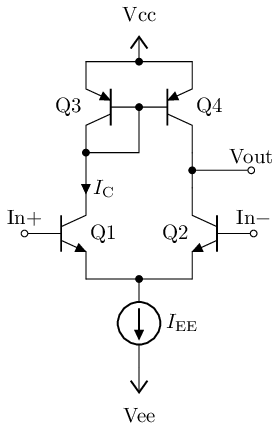

In [4]:
%%tikz -ct
\ctikzset{transistors/arrow pos=end, american currents, european resistors}

\draw (0, 0) node [npn] (Q1) {Q1};
\draw (Q1) ++(1.8, 0) node [npn, xscale=-1] (Q2) {\ctikzflipx{Q2}};
\draw (Q1.E) -- (Q2.E);
\draw (Q1.B) to [short, -o] ++(-0.2, 0) node [above] {In$+$};
\draw (Q2.B) to [short, -o] ++(0.2, 0) node [above] {In$-$};

\draw (Q1.E) ++(0.9, 0) node [circ] {} coordinate (M)
to [I, l={$I_\mathrm{EE}$}, bipoles/length=1.2cm] ++(0, -1.5)
node [vee] {Vee};

%\draw (Q1.C) to [R, l={$R_\mathrm{C}$}, bipoles/length=0.8cm] ++(0, 1.5) coordinate (T);
%\draw (Q2.C) to [R, l_={$R_\mathrm{C}$}, bipoles/length=0.8cm] (Q2.C |- T) -- (T);
\draw (Q1.C) to [short, -*] ++(0, 0.6)
  node [pnp, anchor=C, xscale=-1] (Q3) {\ctikzflipx{Q3}};
\draw (Q3 -| Q2) node [pnp] (Q4) {Q4};
\draw (Q3.E) -- (Q4.E);
\draw (Q3.E) coordinate (T);
\draw (T-|M) node [circ] {} node [vcc] {Vcc};
\draw (Q3.C) -| (Q3.B -|M) node [circ] {};
\draw (Q4.C) -- (Q2.C);

%\draw (Q1.C) to [short, *-o] ++(0.5, 0) node [above] {+};
\draw (Q2.C)++(0, 0.3) to [short, *-o] ++(1.0, 0) node [above] {Vout};
\draw (Q1.C) node [currarrow, rotate=-90] {} node [right] {$I_\mathrm{C}$};

跨导 $\sm{g}{m}=\dfrac{\ui{C}}{\uv{T}}$

差分输入阻抗 $\sm{R}{id}= 2r_\pi= 2\dfrac{\beta}{\sm{g}{m}}=2\dfrac{\beta\,\uv{T}}{\ui{C}}$

输出阻抗 $\sm{R}{o}=\sm{r}{o2}/\!/\sm{r}{o4}=\dfrac{\uv{A2}}{\ui{C}}/\!/\dfrac{\uv{A4}}{\ui{C}} =\dfrac{1}{\ui{C}}\cdot\dfrac{\uv{A1}\uv{A2}}{\uv{A1}+\uv{A2}}$

电压增益 $\sm{A}{v}=\sm{g}{m}\sm{R}{o}=\dfrac{1}{\uv{T}}\cdot\dfrac{\uv{A1}\uv{A2}}{\uv{A1}+\uv{A2}}$

可见 $\sm{A}{v}$ 与 $\ui{C}$ 无关，而 $\sm{R}{id}$ 和 $\sm{R}{o}$ 均 $\propto \dfrac{1}{\ui{C}}$，对于输入级，一般先满足 $\sm{R}{id}$，通常导致 $\sm{g}{m}$ 比较小，实际的增益会比较低。

### PNP Input

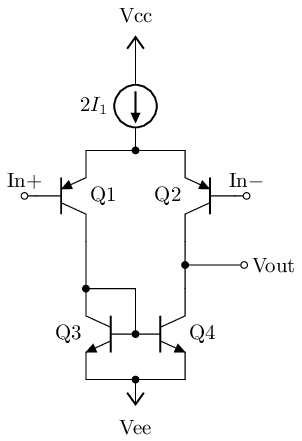

In [4]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, european resistors}

\draw (0, 0) node [npn, xscale=-1] (Q3) {\ctikzflipx{Q3}};
\draw (Q3.B) node [circ] {} node [npn, anchor=B] (Q4) {Q4};
\draw (Q3.C) -| (Q3.B);
\draw (Q3.E) -- (Q4.E);
\draw (Q3.E-|Q3.B) node [circ] {} node [vee] {Vee};

\draw (Q3.C) to [short, *-] ++(0, 0.8)
  node [pnp, anchor=C] (Q1) {Q1};

\draw (Q1 -| Q4) node [pnp, xscale=-1] (Q2) {\ctikzflipx{Q2}};
\draw (Q2.C) -- (Q4.C);
\draw (Q1.E) -- (Q2.E);
\draw (Q1.E-|Q3.B) node [circ] {}
  to [I, invert, l={$2I_1$}, bipoles/length=1.2cm] ++(0, 1.5)
  node [vcc] {Vcc};
\draw (Q4.C) ++ (0, 0.4) to [short, *-o] ++(1, 0) node [right] {Vout};
\draw (Q1.B) to [short, -o] ++(-0.2, 0) node [above] {In$+$};
\draw (Q2.B) to [short, -o] ++(0.2, 0) node [above] {In$-$};

1. 要求 $\sm{R}{in}=2r_\pi=1$MΩ

2. $r_\pi=\dfrac{\beta\,\uv{T}}{I_1}=500$kΩ

3. $\sm{\beta}{P}=50$, $I_1=\dfrac{50\times 26}{500}=2.6$μA

4. $\ui{bias}=\uv{T}/r_\pi=52$nA，与 $\ui{CQ}$ 和 $\beta$ 无关。

## Put it together

### Two-stage microphone amplifier

第一级是 common-emitter，提供电压增益，但是其输出阻抗太高，带不动扬声器负载（十几 Ω）。所以加一级 emitter follower，以实现阻抗变换，把输出阻抗降到与扬声器相近的水平。

$\sm{A}{v1}\approx\dfrac{R_1}{R_2}$

$\sm{R}{in}\approx r_{\pi 1} + (1+\beta)\sm{R}{3} = \dfrac{\beta}{\sm{g}{m1}} + (1+\beta)\sm{R}{3} $

$\sm{R}{o}\approx \sm{r}{e 2} = \dfrac{\alpha}{\sm{g}{m2}}=\dfrac{\uv{T}}{\ui{E2}}$

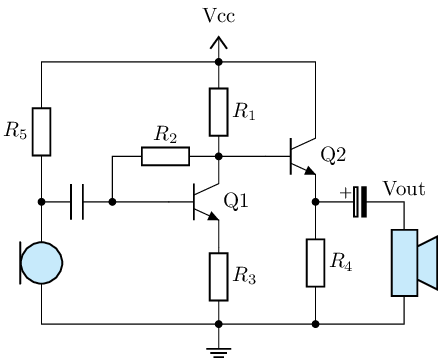

In [3]:
%%tikz -ct

\ctikzset{transistors/arrow pos=end, american currents, american voltages, european resistors, misc/fill=cyan!20}

\draw (0, 0) node [npn] (Q1) {Q1};
\draw (Q1.E) to [R, l={$R_3$}, bipoles/length=1cm] ++(0, -1.0)
  to [short, -*] ++(0, -0.3)
  coordinate (G) node [ground] {};
\draw (Q1.C) to [R, l_={$R_1$}, bipoles/length=1cm] ++(0, 1.5)
  to [short, -*] ++(0, 0.1) node [vcc] {Vcc}
  coordinate (T);
\draw (Q1.C) to [R, l_={$R_2$}, bipoles/length=1cm] ++(-1.8, 0)
  coordinate (C) |- (Q1.B);
\draw (Q1.B-|C) node [circ] {} to [C, bipoles/length=1cm] ++(-1.2, 0)
  coordinate (MIC)
  to [tlmic, mirror, *-] (MIC|-G) -- (G);
\draw (MIC) to [R, l={$R_5$}, bipoles/length=1cm] (MIC|-T) -- (T);

\draw (Q1.C) to [short, *-] ++(0.8, 0) node [npn, anchor=B] (Q2) {Q2};
\draw (Q2.C) |- (T);
\draw (Q2.E) node [circ] {} to [eC, bipoles/length=1cm] ++(1.5, 0)
  coordinate (OUT) node [above] {Vout}
  to [loudspeaker] (OUT|-G) -- (G);

\draw (Q2.E) to [R, l={$R_4$}, bipoles/length=1cm] (Q2.E|-G)
  node [circ] {};

In [6]:
ng.circ('''
  Vcc  vcc   0     6V

  * 1st stage, common-emitter
  R1   vcc   q1c   1k
  R2   q1c   q1b   100k
  R3   q1e   0     100
  C2   q1e   0     1u
  Q1   q1c   q1b   q1e   NPN

  * 2nd stage, emitter follower
  Q2   vcc   q1c   q2e   NPN
  R4   q2e   0     100
  
  C1   vin   q1b   1u
  Vin  vin   0     AC SINE(1V 50mV 1k)

  C3    q2e   out  22u
  Rload out   0    16
  .model NPN NPN(IS=2fA BF=150 VAF=150)
''')
print_op()

       out =      0.0 uV
       q1b =   1.0169 V
       q1c =   2.9318 V
       q1e =   0.2928 V
       q2e =   2.1563 V
       vcc =   6.0000 V
vcc#branch =  -24.491 mA
       vin =   1.0000 V
vin#branch =    0.000 uA


0.0993069766189818
0.7186926254274055


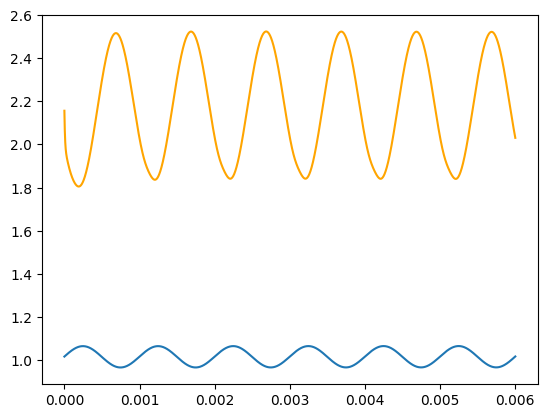

In [7]:
ng.cmd('tran 1u 6m')

fig, ax = plt.subplots()
Vin = ng.vector('q1b')
plt.plot(ng.vector('time'), Vin)
print(max(Vin) - min(Vin))

# ax2 = ax.twinx()
Vout = ng.vector('q2e')
plt.plot(ng.vector('time'), Vout, 'orange')
print(max(Vout) - min(Vout))

0.6357251381441207


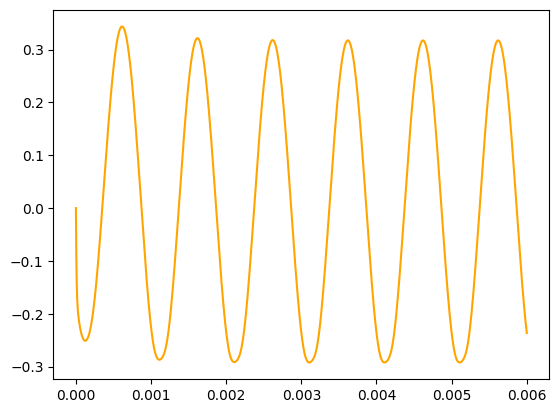

In [8]:
Vout = ng.vector('out')
plt.plot(ng.vector('time'), Vout, 'orange')
print(max(Vout) - min(Vout))

可见输出波形有比较明显的非线性失真。

实际使用中直接用 LM386 即可。

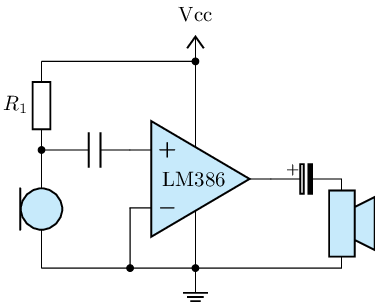

In [22]:
%%tikz -ct

\ctikzset{european resistors, amplifiers/fill=cyan!20, misc/fill=cyan!20}

\draw (0, 0) node [op amp, noinv input up] (OA) {LM386};
\draw (OA.+) to [C, bipoles/length=1cm] ++(-1.2, 0)
  to [short] ++(-0.3, 0)
  coordinate (MIC)
  to [tlmic, mirror, *-] ++(0, -2) coordinate (G);
\draw (MIC) to [R, l={$R_1$}, bipoles/length=1cm] ++(0, 1.5)
  coordinate (T);
\draw (OA.up) |- (T);
\draw (OA.-) to [short, -*] (OA.- |- G);
\draw (OA.down) to [short, -*] (OA.down |- G) node [ground] {};
\draw (OA.up |- T) node [circ] {} node [vcc] {Vcc};
\draw (OA.out) to [eC, bipoles/length=1cm] ++(1.2, 0) coordinate (OUT)
  to [loudspeaker] (OUT|-G) -- (G);

### RC4558 op amp

https://nuedc.org/rc4558/